In [1]:
import pandas as pd
import datetime as dp
import numpy as np

In [2]:
dataset_path = 'E:/Datasets/titanic/raw dataset'

In [3]:
train_raw = pd.read_csv(f'{dataset_path}/train.csv')
test_raw = pd.read_csv(f'{dataset_path}/test.csv')

# Summary

In [4]:
train_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
def count_infs(series):
    if pd.api.types.is_numeric_dtype(series):
        return np.isinf(series).sum()
    return 0

summary = pd.DataFrame({
    'dtype': train_raw.dtypes,
    'n_nans': train_raw.isna().sum(),
    'n_infs': train_raw.apply(count_infs)
})
summary.reset_index(inplace=True)
summary.rename(columns={'index': 'column'}, inplace=True)
print(summary)

         column    dtype  n_nans  n_infs
0   PassengerId    int64       0       0
1      Survived    int64       0       0
2        Pclass    int64       0       0
3          Name   object       0       0
4           Sex   object       0       0
5           Age  float64     177       0
6         SibSp    int64       0       0
7         Parch    int64       0       0
8        Ticket   object       0       0
9          Fare  float64       0       0
10        Cabin   object     687       0
11     Embarked   object       2       0


Same for the test set

In [13]:
summary = pd.DataFrame({
    'dtype': test_raw.dtypes,
    'n_nans': test_raw.isna().sum(),
    'n_infs': test_raw.apply(count_infs)
})
summary.reset_index(inplace=True)
summary.rename(columns={'index': 'column'}, inplace=True)
print(summary)

         column    dtype  n_nans  n_infs
0   PassengerId    int64       0       0
1        Pclass    int64       0       0
2          Name   object       0       0
3           Sex   object       0       0
4           Age  float64      86       0
5         SibSp    int64       0       0
6         Parch    int64       0       0
7        Ticket   object       0       0
8          Fare  float64       1       0
9         Cabin   object     327       0
10     Embarked   object       0       0


In [37]:
all_columns = train_raw.columns
feature_names = all_columns[~np.isin(all_columns, ['Survived', 'PassengerId', 'Name'])] #All columns that will be used for prediction

In [34]:
train_raw.duplicated().sum()

np.int64(0)

In [35]:
test_raw.duplicated().sum()

np.int64(0)

No duplicated values

# Wrangling

I'll start wrangling the dataset a little bit.
Lets map the sex column to a numerical value:

In [24]:
train_w = train_raw.copy()
test_w = test_raw.copy()
train_w['Sex'] = train_w['Sex'].map({'male': 0, 'female': 1})
test_w['Sex'] = test_w['Sex'].map({'male': 0, 'female': 1})

There are three columns with missing data. I could simply drop the two rows for the embarked column, it wont do much difference.

In [25]:
train_w = train_w.dropna(subset=['Embarked'])

In [26]:
train_w.loc[:, 'Cabin'] = train_w['Cabin'].fillna('unknown')
test_w.loc[:, 'Cabin'] = test_w['Cabin'].fillna('unknown')

The age column has a lot of nans, and I don't know how could this be afecting.

In [39]:
print(train_w[numerical_cols].corr())

          Pclass       Age     SibSp     Parch      Fare
Pclass  1.000000 -0.390938  0.081656  0.016824 -0.548193
Age    -0.390938  1.000000 -0.319953 -0.213799  0.086169
SibSp   0.081656 -0.319953  1.000000  0.414542  0.160887
Parch   0.016824 -0.213799  0.414542  1.000000  0.217532
Fare   -0.548193  0.086169  0.160887  0.217532  1.000000


I am going to impute missing values by training a small RandomForest predictor

In [28]:
from sklearn.ensemble import RandomForestRegressor
features = ['Pclass', 'SibSp', 'Parch', 'Fare', 'Sex'] #Even if fare has a small correlation could be helpfull

train_age = train_w[train_w['Age'].notna()].copy()
test_age = train_w[train_w['Age'].isna()].copy()

X_train = train_age[features]
y_train = train_age['Age']
X_test = test_age[features]

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

predicted_ages = model.predict(X_test) #Predict missing values

train_w.loc[train_w['Age'].isna(), 'Age'] = predicted_ages #Fill the dataset, imputing the data

In [29]:
#And I repeat for the test set, using the same predictor
pred_age = test_w[test_w['Age'].isna()].copy()
X_pred = pred_age[features]

predicted_ages = model.predict(X_pred)

test_w.loc[test_w['Age'].isna(), 'Age'] = predicted_ages

In [33]:
#And finally I won get myself preocupied for the only one NaN fare value, i'll replace it with the mean 
test_w.loc[test_w['Fare'].isna(), 'Fare'] = 32.204208

# Univariate analysis

## Numerical values

In [67]:
#Numerical data
numerical_cols = train_w[feature_names].describe().columns
numerical_cols = numerical_cols[~np.isin(numerical_cols, ['Sex', 'SibSp', 'Parch', 'Pclass'])] #Sex and Pclass gets into this group for the transformation, they are categorical
train_w[numerical_cols].describe()  

,Age,Fare
count,889.000000,889.000000
mean,29.536130,32.096681
std,13.696944,49.697504
min,0.420000,0.000000
25%,21.000000,7.895800
50%,28.000000,14.454200
75%,37.000000,31.000000
max,80.000000,512.329200


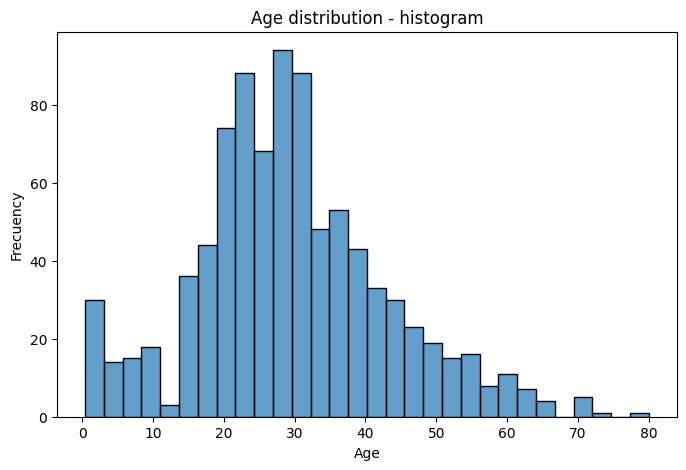

In [59]:
#Age 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(train_w['Age'].dropna(), bins=30, kde=False, edgecolor='k', alpha=0.7)
plt.title('Age distribution - histogram')
plt.xlabel('Age')
plt.ylabel('Frecuency')
plt.show()

There is an important bias towards babys

C:\Users\Felpipe\AppData\Local\Temp\ipykernel_26140\1057040622.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_w['Fare'].dropna(), shade=True)


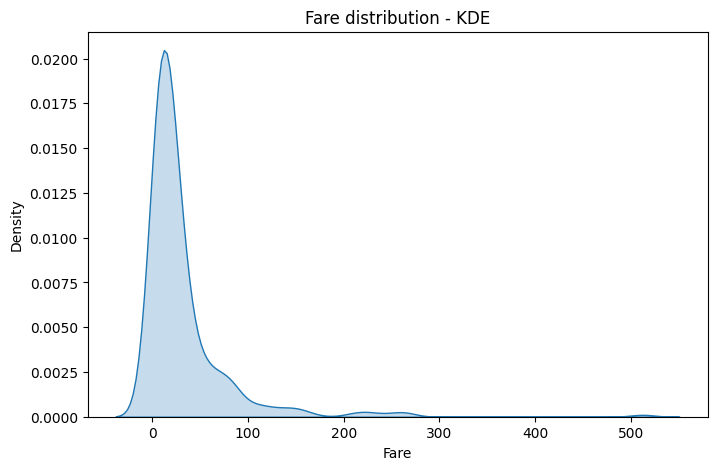

In [65]:
plt.figure(figsize=(8, 5))
sns.kdeplot(train_w['Fare'].dropna(), shade=True)
plt.title('Fare distribution - KDE')
plt.xlabel('Fare')
plt.ylabel('Density')
plt.show()

In [ ]:
plt.figure(figsize=(6, 8))
sns.violinplot(y=df['Age'].dropna())
plt.title('Distribución de Edad - Violin Plot')
plt.xlabel('')
plt.ylabel('Edad')
plt.show()

## Categorical values

In [69]:
train_w['SibSp'].value_counts()

SibSp
0    606
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64

In [68]:
train_w['Parch'].value_counts()

Parch
0    676
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64

In [71]:
#Categorical data
categorical_cols = train_w[feature_names].describe(include='object').columns
categorical_cols = np.append(categorical_cols, ['Sex', 'SibSp', 'Parch', 'Pclass']) #Those that got left behind
subset = train_w.copy()
subset['Sex'] = train_w['Sex'].map({0 : 'male', 1 : 'female'})
subset['SibSp'] = train_w['SibSp'].map({0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 8: '8'})
subset['Parch'] = train_w['Parch'].map({0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6'})
subset['Pclass'] = train_w['Pclass'].map({1 : 'first', 2 : 'second', 3 : 'third'})
subset[categorical_cols].describe(include='object') 

,Ticket,Cabin,Embarked,Sex,SibSp,Parch,Pclass
count,889,889,889,889,889,889,889
unique,680,147,3,2,7,7,3
top,347082,unknown,S,male,0,0,third
freq,7,687,644,577,606,676,491


Sex is already a one hot encoded value, so we leave it like that. Pclass, which is categorical is also ordinal, so we can again leave it be like that

In [63]:
categorical_cols

array(['Ticket', 'Cabin', 'Embarked', 'Sex', 'Pclass'], dtype=object)